HMM-DDM: Mouse Data
========================
In this notebook we will analyse a dataset of mice performing a two-alternative forced choice (TAFC) task developed in Kane, Senne, and Scott, 2025. mice performed this task daily in two-hour periods.

In [1]:
using HiddenMarkovModels
using DriftDiffusionModels
using Plots
using CSV
using DataFrames
using Dates
using Random
using Distributions
using LinearAlgebra
using StatsBase

## Load and Preprocess the data

In [2]:
ddir = "../data/rat_daily.csv"
# load in the data
df = CSV.File(ddir) |> DataFrame;

In [3]:
# Group by animal name and count trials
trial_counts = combine(groupby(df, :name), nrow => :trial_count)

# Sort by count in descending order
sort!(trial_counts, :trial_count, rev=true)

# pick a mouse of interest (start with mouse of most trials)
moi = trial_counts[1, :name]

# get the data for the mouse of interest
mouse_df = df[df.name .== moi, :]

# Filter out trials with "omission" outcome
valid_trials = findall(outcome -> outcome != "omission", mouse_df.outcome)
filtered_df = mouse_df[valid_trials, :]

# Map correct -> 1 and incorrect -> -1 (only for error and correct, omissions are gone)
numeric_outcomes = [outcome == "correct" ? 1 : -1 for outcome in filtered_df.outcome]

# Get reaction times, filter out "NAN" values
valid_rt_indices = findall(rt -> uppercase(string(rt)) != "NAN", filtered_df.rt)

# Apply both filters to keep data aligned
final_df = filtered_df[valid_rt_indices, :]
final_outcomes = numeric_outcomes[valid_rt_indices]

# Convert RTs to Float64
final_rts = [parse(Float64, rt) for rt in final_df.rt]

# Extract just the date part from the timestamp strings
dates = [Date(split(dt)[1]) for dt in final_df.trial_datetime]

# Get unique dates in chronological order
unique_dates = sort(unique(dates))

# Create a vector of vectors, where each inner vector contains DDMResults for one day
results_by_date = Vector{Vector{DDMResult}}()

for date in unique_dates
    # Get indices for this date
    day_indices = findall(dates .== date)
    
    # Skip days with no valid data
    if isempty(day_indices)
        continue
    end
    
    # Extract RTs and outcomes for this date
    day_rts = final_rts[day_indices]
    day_outcomes = final_outcomes[day_indices]
    
    # Create DDMResult objects for this day
    day_results = [DDMResult(rt, choice) for (rt, choice) in zip(day_rts, day_outcomes)]
    
    # Add to our vector of vectors
    push!(results_by_date, day_results)
end

# Now calculate the sequence ends (cumulative sum of lengths)
seq_ends = cumsum([length(seq) for seq in results_by_date])

# Concatenate all results into a single vector
all_results = reduce(vcat, results_by_date)

49957-element Vector{DDMResult}:
 DDMResult(0.7706, -1)
 DDMResult(0.9214, -1)
 DDMResult(0.7649, -1)
 DDMResult(0.662, 1)
 DDMResult(0.6743, 1)
 DDMResult(1.0067, 1)
 DDMResult(0.7572, -1)
 DDMResult(0.7443, -1)
 DDMResult(1.0416, 1)
 DDMResult(0.523, 1)
 ⋮
 DDMResult(0.6389, 1)
 DDMResult(0.8554, 1)
 DDMResult(0.9489, 1)
 DDMResult(1.2433, 1)
 DDMResult(0.9811, 1)
 DDMResult(0.689, 1)
 DDMResult(1.0855, 1)
 DDMResult(1.8215, -1)
 DDMResult(1.8237, 1)

# Visualize the correct and error RT distirbutions

In [4]:
correct_trials = [x for x in all_results if x.choice == 1]
incorrect_trials = [x for x in all_results if x.choice == -1];

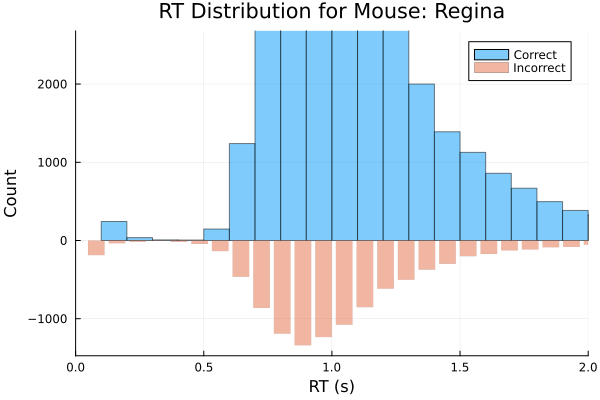

In [5]:
rt_dist_plot = histogram([x.rt for x in correct_trials], bins=100, alpha=0.5, label="Correct", legend=:topright)
incorrect_rts = [x.rt for x in incorrect_trials]
h = fit(Histogram, incorrect_rts, range(0, maximum(incorrect_rts), length=101))
bar!(h.edges[1][1:end-1], -h.weights, width=step(h.edges[1]), 
     alpha=0.5, 
     label="Incorrect")
# Adjust y-axis to make room for the downward bars
xlabel!("RT (s)")
ylabel!("Count")
title!("RT Distribution for Mouse: $moi")
ylims!(minimum([-h.weights; 0]) * 1.1, maximum(h.weights) * 2)
xlims!(0, 2)

## Perform Cross Validation

For these CV procedure we will do the following procedure:

- Shuffle the data across sessions
- Split the data into 5 folds
- For each numbert of states K in [2, 3, 4, 5]
    - For each fold
        - For 10 itemouseions
            - Randomly initialize the model parameters
            - Fit the model to the training data
            - Evaluate the model on the test data
            - Store the model parameters and performance metrics
        - Store the best model parameters and performance metrics
        - Compute the mean and standard deviation of the performance metrics across itemouseions

- Refit the best model of the selected K states to the entire dataset

In [6]:
cv_results, nobs = crossvalidate(results_by_date; n_states=2, n_folds=3, n_iter=3)

┌ Info: ⇢ evaluating 1 hidden state(s)
└ @ DriftDiffusionModels \Users\ryansenne\Documents\GitHub\DriftDiffusionModels.jl\src\Utilities.jl:50


MethodError: MethodError: no method matching DriftDiffusionModel(::Float64, ::Float64, ::Float64, ::Float64)

Closest candidates are:
  DriftDiffusionModel(::Float64, ::Float64, ::Float64, ::Float64, !Matched::Float64)
   @ DriftDiffusionModels \Users\ryansenne\Documents\GitHub\DriftDiffusionModels.jl\src\DDM.jl:7
  DriftDiffusionModel(::Any, ::Any, ::Any, ::Any, !Matched::Any)
   @ DriftDiffusionModels \Users\ryansenne\Documents\GitHub\DriftDiffusionModels.jl\src\DDM.jl:7


In [7]:
function calculate_ll_ratio(ℓℓ::Float64, ℓℓ₀::Float64, n::Int)
    ll_ratio = ℓℓ - ℓℓ₀
    return ll_ratio / (n * log(2))
end

calculate_ll_ratio (generic function with 1 method)

In [8]:
mean(calculate_ll_ratio.( cv_results[2], cv_results[1], nobs ), dims=1)

UndefVarError: UndefVarError: `cv_results` not defined

In [9]:
plot(xlabel="k", ylabel="loglikelihood")
for i in 2:2
    scatter!([i for _ in 1:3], mean(calculate_ll_ratio.( cv_results[i], cv_results[1], nobs), dims=1)')
end
display(current())

UndefVarError: UndefVarError: `cv_results` not defined

In [9]:
# generate a HMM to start from
trans_guess = [0.95 0.05; 0.05 0.95]
init_guess = [0.99, 0.01]

ddm_1_guess = DriftDiffusionModel(10, 0.1, 0.5, 0.25, 1)
ddm_2_guess = DriftDiffusionModel(2, 1.0, 0.5, 0.75, 1)

dists_guess = [ddm_1_guess, ddm_2_guess]

# create a prior distirbution for the initial states and transition matrix (sticky HMM)
α₀ = ones(2)
αₜ = ones(2, 2) .* 2
# αₜ[diagind(αₜ)] .= 2

hmm = PriorHMM(init_guess, trans_guess, dists_guess, αₜ, α₀)

hmm_est, lls = baum_welch(hmm, all_results; seq_ends=seq_ends)

(PriorHMM{Float64, DriftDiffusionModel}([0.19796793079368386, 0.8020320692063161], [0.6532560937342874 0.3467439062657126; 0.03221476635157894 0.9677852336484211], DriftDiffusionModel[DriftDiffusionModel(2.245319182886931, 0.16253866310227502, 0.5, 0.0010000000000000002, 1.0), DriftDiffusionModel(1.5882227439536902, 0.9082174788434079, 0.5, 0.6117487073705551, 1.0)], [2.0 2.0; 2.0 2.0], [1.0, 1.0]), [-5.020000000000202e18, -48166.99034838923, -46757.906899141206, -46274.6833374073, -46033.78557168585, -45870.96086350817, -45748.535783388914, -45648.80574401242, -45565.50110257905, -45497.42233165305  …  -45279.198630940504, -45279.19857181198, -45279.198524725776, -45279.19848722795, -45279.198457365, -45279.19843358171, -45279.19841463988, -45279.19839955359, -45279.19838753783, -45279.19837796746])

## Confirm the LL converges!

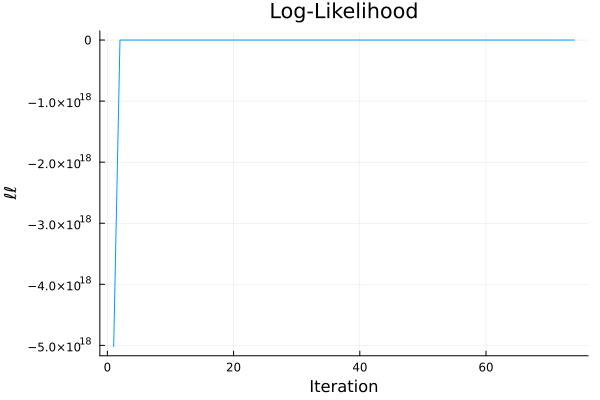

In [10]:
plot(lls, title="Log-Likelihood", xlabel="Iteration", ylabel="ℓℓ", legend=false)

## Plot the Posterior Distribution of the States


In [11]:
# get the posterior distribution of the hidden states
posterior = forward(hmm_est, all_results; seq_ends=seq_ends)
γ = posterior[1]

2×49957 Matrix{Float64}:
 0.159254  0.0995005  0.0752744  0.234627  …  0.0163385  0.0986478  0.0801389
 0.840746  0.900499   0.924726   0.765373     0.983662   0.901352   0.919861

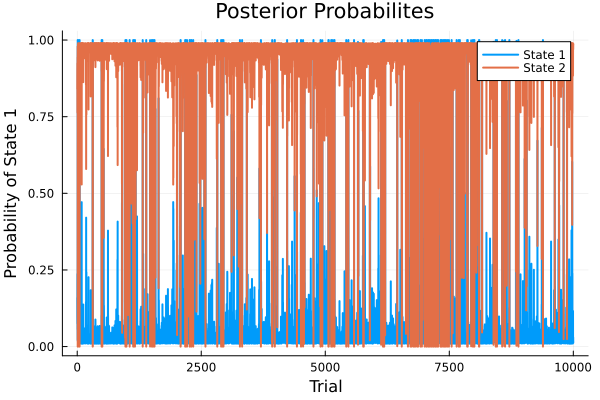

In [17]:
plot(γ[1, 1:10000], title="Posterior Probabilites", xlabel="Trial", ylabel="Probability of State 1", label="State 1", linewidth=2)
plot!(γ[2, 1:10000], label="State 2", linewidth=2)